# MRP Extended Kalman Filter Demo

This demo introduces a JAXitude workflow estimating the attitude evolution of a tumbling spacecraft using simulated data using modified Rodrigues parameters (MRPs).  We'll make use of four JAXitude tools for this exercise:
- `jaxitude.quaternions.Quaternion()` to transform the simulated quaternion data to principal axes and angles,
- `jaxitude.operations.error.QuatNoise` to appropriately simulate measurement error from the simulated quaternion data,
- `jaxitude.rodrigues.MRP()` to convert simulated attitude measurements to MRPs,
- `jaxitude.determination.ekf.MRPEKF` to build the MRP extended Kalman filter algorithm.

As always with JAXitude, any vector data must be transformed to column vectors (I.e. `jnp.array([1., 0., 0.])` $\rightarrow$ `jnp.array([1., 0., 0.]).reshape((3, 1))`).

## Step Zero: Load Simulation Data

We need to import the training data provided under the local directory `data/`.  We'll be using the `tumbling1/` data set for this demo.

In [162]:
from pathlib import Path
import sys
import os
sys.path.append(str(Path(os.getcwd()).parent))
from typing import Tuple

from numpy import genfromtxt
import jax.numpy as jnp
from jax import config
config.update('jax_enable_x64', True)  # Default to double float precision.

data_path = Path('data/') / 'tumbling1'

# Load observed gyroscope data.
with open(data_path / 'gyro-0.csv', 'r') as f:
    w_obs_data = jnp.asarray(genfromtxt(f, delimiter=',', skip_header=1))

# Load true gyroscope data.
with open(data_path / 'ref_gyro.csv', 'r') as f:
    w_true_data = jnp.asarray(genfromtxt(f, delimiter=',', skip_header=1))

# Load true attitude data (parameterized with quaternions).
with open(data_path / 'ref_att_quat.csv', 'r') as f:
    b_true_data = jnp.asarray(genfromtxt(f, delimiter=',', skip_header=1))

# Load true attitude data (parameterized with Euler angles).
with open(data_path / 'ref_att_euler.csv', 'r') as f:
    ea_true_data = jnp.asarray(genfromtxt(f, delimiter=',', skip_header=1))

# load simulation time data.
with open(data_path / 'time.csv', 'r') as f:
    t_data = jnp.asarray(genfromtxt(f, delimiter=',', skip_header=1))

# Remember: all vector data must be transformed to column vectors to utilize
# JAXitude calculations!  Also, convert deg/s to rad/s
n_steps = jnp.shape(t_data)[0]
w_obs_data = w_obs_data.reshape((n_steps, 3, 1)) * jnp.pi / 180.
w_true_data = w_true_data.reshape((n_steps, 3, 1)) * jnp.pi / 180.
b_true_data = b_true_data.reshape((n_steps, 4, 1))
ea_true_data = ea_true_data.reshape((n_steps, 3, 1)) * jnp.pi / 180.

## Step One: Simulate Attitude Measurements

Since the simulated attitudes are parameterized as quaternions, we'll make use of `jaxitude.operations.noise.QuatNoise` to simulate measurement uncertainty


In [2]:
from jax import vmap
from jax.random import PRNGKey, split

from jaxitude.operations.error import QuatNoise

# We need a random key to generate noise.
key = PRNGKey(1)

# Quaternion rotation angle error standard deviation will be set to five degrees.
sigma_dtheta = 5. * jnp.pi / 180.  # Convert to radians for JAXitude!


# For this helper function, we'll define it for a single key, b argument pair
# and then vectorize with vmap.
@vmap
def addnoise_sample(key: int, b: jnp.ndarray) -> jnp.ndarray:
    """ This helper function takes the quaternion set b, makes sure it is
        normalized, and adds noise.
    """
    # We get the rotation matrix R(b) by calling the instantiated Quaternion
    # object.  Note that we also normalized the quaternion set.
    return QuatNoise.addnoise(key, b / jnp.linalg.norm(b), sigma_dtheta)

# Simulate measured attitude time series.
key, subkey = split(key)
b_obs_data = addnoise_sample(split(subkey, n_steps),b_true_data)


## Step Two: MRP Conversion

Since we are going to feed all this data into an MRP EKF algorithm, we next want to convert the heading measurements to MRPs.  Again, we'll make use of JAXitude to simplify this workflow.

In [3]:
from jaxitude.quaternions import Quaternion
from jaxitude.rodrigues import shadow

# Let's vectorize converting from quaternions to MRPs
@vmap
def mrp_from_quat(b: jnp.ndarray) -> jnp.ndarray:
    """ Wrapper for converting quaternions to MRPs using the Quaternion object.
    """
    s = Quaternion(b).get_s_from_b()
    return jnp.where(
        jnp.linalg.norm(s) < 1.,
        s,
        shadow(s)
    )

mrp_obs_data = mrp_from_quat(b_obs_data)
mrp_true_data = mrp_from_quat(b_true_data)

## Step Three: MRP EKF Algorithm

Now we need to build the MRP EKF algorithm using JAX and JAXitude using the `jaxitude.estimation.ekf.MRPEKF` class.

MRPs are useful because they 1) linearize well, and 2) can be nonsingular if the MRP shadow set is utilized (see [Karlgaard 2010b](https://link.springer.com/article/10.1007/BF03321529); also available via [Professor Hanspeter Schaub's website](https://hanspeterschaub.info/journals.html)).
MRP dynamics $\dot{\sigma}(t)$ are a funciton of $\sigma(t)$ and attitude rates $\mathbf{\omega}(t)$:

$\dot{\sigma}(t) = \frac{1}{4}[B(\sigma(t))]\mathbf{\omega}(t)$

The matrix function $\frac{1}{4}[B(\sigma(t))]$ and the differential equation above are both reaidly available at `jaxitude.operations.evolution.B_crp()` and `jaxitude.operations.evolution.evolve_crp()`, respectfully.
Indeed, JAXitude's `MRPEKF` class utilizes these functions directly.

Let's start by importing `MRPEKF` and defining the sampling $dt$ for the filter.

In [161]:
from jaxitude.estimation.ekf import MRPEKF

dt = t_data[1] - t_data[0]  # Sampling is constant.


At each time step $t_k$ in this data set, we have observed attitude MRP values $\hat{\sigma}_k$ and observed attitude rate vectors $\hat{\mathbf{\omega}}_k$. 
We will use Farrenkopf's gyroscopic model to relate $\hat{\mathbf{\omega}}_k$ to the true attitude rate vector $\mathbf{\omega}_k$:

$\hat{\mathbf{\omega}}_k = \mathbf{\omega}_k + \mathbf{b}_k + \eta_{\mathbf{\omega},k}$

where $\eta_{\mathbf{\omega},k} \sim \mathcal{N}(0, [R_{\mathbf{\omega}}])$ are the uncorrelated error in attitude measurements sampled with covariance $R_{\mathbf{\omega}}$, and $\mathbf{b}_k$ is the gyroscopic bias for each rotational axis at time step $k$.
Note now that $\mathbf{b}_k = \mathbf{b}(t = t_k)$ is going to be another set of state parameters we are going to track.
The Farrenkopf model for $\mathbf{b}(t)$ is a Gaussian random walk:

$\dot{\mathbf{b}}(t) =\eta_{\mathbf{b}}$

where $\eta_{\mathbf{b}} \sim \mathcal{N}(0, [R_{\mathbf{b}}])$ is the gyroscope rate random error vector with covariance $R_{\mathbf{b}}$.

We know, or should be able to estimate, the measurement covariance matrices $[R_{\mathbf{\omega}}]$ and $[R_{\mathbf{b}}]$ *a priori*, so let's define these real quick.

In [164]:
sigmaR_w = 1e-4  # Estimated from simulated data set.
sigmaR_b =  3. * jnp.pi / 180.  # This is the gyroscope bias simulation value
R_w = jnp.eye(3) * sigmaR_w**2.
R_b = jnp.eye(3) * sigmaR_b**2.

As mentioned, not only will we be estimating the attitude $\sigma(t)$ of the tumbling craft, but will also be estimating the gyroscope bias $\mathbf{b}$.
The full state vector will therefore be a six-dimensional column vector $\mathbf{x}(t) = [\sigma(t),\mathbf{b}(t)]^T$.
Similarly, we can stack the two error vectors to get $\mathbf{\eta} = [\mathbf{\eta}_{\mathbf{\omega}},\mathbf{\eta}_{\mathbf{b}}]^T$.
Now we need to figure out the full state dynamics equation $\dot{\mathbf{x}}(t)$

First, we want to plug the observed attitude rate $\hat{\mathbf{\omega}}(t)$ written in terms of $\mathbf{\omega(t)}$, $\mathbf{\eta}_{\mathbf{\omega}}$, and $\mathbf{b}(t)$ into the MRP differential equations provided above.
Dropping all of the '$(t)$' for brevity, we end up with the following differential equation:

$\dot{\sigma} = \frac{1}{4}[B(\sigma(t))](\mathbf{\omega} - \mathbf{\eta}_{\mathbf{\omega}} - \mathbf{b})$.

Now, let's combine the equation above with the differential equation for $\mathbf{b}$ to get a full set of equations for $\dot{\mathbf{x}}(t)$.

$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}) + \mathbf{g}(\mathbf{\eta})$, where

$\mathbf{f}(\mathbf{x}) = \begin{bmatrix}\frac{1}{4}[B(\sigma(t))](\mathbf{\omega} - \mathbf{\eta}_{\mathbf{\omega}}) \\ \mathbf{0} \end{bmatrix}$, and

$\mathbf{g}(\mathbf{\eta}) = \begin{bmatrix}-\frac{1}{4}[B(\sigma(t))]\mathbf{\eta}_{\mathbf{\omega}} \\ \mathbf{\eta}_{\mathbf{b}} \end{bmatrix}$.

To estimate the state of the system after a time step $dt$, we can integrate the dynamics $\dot{\mathbf{x}}$ starting from state $\mathbf{x}_{k - 1}$ corresponding to time $t_{k - 1}$ and integrating to state $\mathbf{x}_{k}$ corresponding to time $t_{k}$.
JAXitude does this numerical integration using Euler's method, although other integrators are available for custom workflows.

JAXitude's `MRPEKF` incorporates methods to perform these calculations (`MRPEKF.f()`, `MRPEKF.g()`, and `MRPEKF.pred_x()`), along with methods to linearize both $\mathbf{f}$ and $\mathbf{g}$ using JAX's `jacfwd` function.

Let's initialize $\mathbf{x}$ using the observed MRP values and what we know about the simulated gyroscope bias for this data set.

In [165]:
# The bias should be around three degrees for all gyroscope axes.
b = jnp.full((3, 1), 3. * jnp.pi / 180.)

# The initial MRP values will be the mean of the first five observations.
s0 = jnp.mean(mrp_obs_data[:5], axis=0)
x = jnp.vstack([s0, b])


EKF also estimates the state covariance matrix $[P]$ using the process covariance matrix $[Q]$ by linearizing the dynamics about the current state estimate.
JAXitude's `MRPEKF` class does this linearization and propagation for you with the `MRPEKF.tangent_f()` and `MRPEKF.tangent_g()` functions. 
It also integrates the Ricatti equation for $[\dot{P}]$ to estimate $[P]_k$ starting from $[P]_{k - 1}$:

$[\dot{P}] = [F][P] + [P][F]^T + [G][\text{diag}([R_w], [\mathbf{0}]_{3\times3})][G]^T + [Q]$,

where $[F]$ and $[G]$ are the dynamical system matrices linearized around $\mathbf{x}_k$ and $\mathbf{\eta} = \mathbf{0}$. 
This integration is implemented with `MRPEKF.pred_P_ricatti()`.

The process covariance matrix $Q$ needs to be provided.
Admittedly, getting this matrix right is tricky, while interpreting what it means is even more difficult.
Basically, $Q$ is tells us the uncertainty in how we are modeling the dynamics. 
We'll add a gain factor `q_gain` that we can tune as well.
We'll also initialize $P$ as a multiple of $Q$.

In [189]:
from scipy.linalg import block_diag

# Estimating the process covariance matrix Q is challenging.  
sigmaq_w = 1e-2
sigmaq_b = 1e-3
q_gain = 10.
Q = q_gain * block_diag(
    jnp.eye(3) * sigmaq_w**2,
    jnp.eye(3) * sigmaq_b**2
)

# The initial state covariance will be the process covariance matrix multiplied
# by a constant > 1.
P = 5. * Q.copy()

Let's bring it all together with a helper function `step()`, which we will wrap `MRPEKF.filter_step()` and which we will also jitify, looping through all 1800 time steps. 
Note that using `jax.jit()` speeds up the for loop by between a factor of 10 and 20!

As one would hope, `MRPEKF` also calculates the Kalman gain at each step (see `MRPEKF.get_K()`). 
I will not write out these steps here, but refer to the Wikipedia page on [Extended Kalman Filters](https://en.wikipedia.org/wiki/Extended_Kalman_filter) if you want to see the details.


In [190]:
from jax import jit

import importlib
from jaxitude.estimation import ekf
from jaxitude.operations import evolution
from jaxitude.operations import linearization 
importlib.reload(evolution)
importlib.reload(linearization)
importlib.reload(ekf)

# Always reset your initial conditions when you run.
s0 = jnp.mean(mrp_obs_data[:5], axis=0)
x = jnp.vstack([s0, b])
P = 5. * Q.copy()

# This function makes it easier to jit.
@jit
def step(
    x: jnp.ndarray,
    P: jnp.ndarray,
    w_obs: jnp.ndarray,
    s_obs: jnp.ndarray
) -> Tuple[jnp.ndarray]:
    """ MRP EKF filter step for given matrices R_w, R_b, and Q.
    """
    return MRPEKF.filter_step(
        x, P, w_obs, s_obs,
        R_w, R_b, Q, dt, P_propogation_method='ricatti'
    )


# Loop through and append new estimates.
x_list = []
P_list = []
for i in range(n_steps):
    x_list.append(x)
    P_list.append(P)
    x, P = step(
        x, P,
        w_obs_data[i], mrp_obs_data[i],
    )

# Convert to arrays.
x_arr = jnp.array(x_list)
P_arr = jnp.array(P_list)


Now let's plot the results!

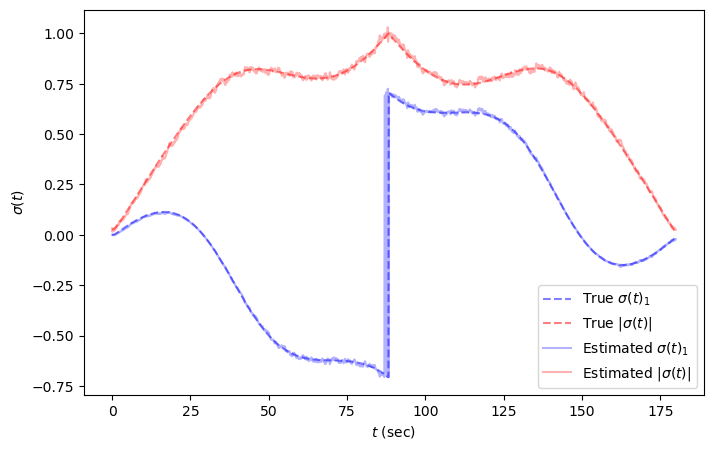

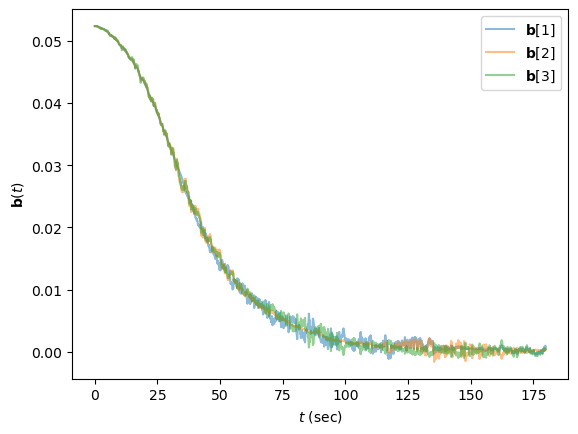

In [191]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(
    t_data[:], mrp_true_data[:, 0, 0], alpha=0.5, color='blue', ls='--',
    label=r'True $\sigma(t)_1$'
)
plt.plot(
    t_data[:], jnp.linalg.norm(mrp_true_data[:, :, 0], axis=1), alpha=0.5,
    color='red', label=r'True $|\sigma(t)|$', ls='--'
)
plt.plot(
    t_data[:], x_arr[:, 0, 0], alpha=0.3, color='blue', ls='-',
    label=r'Estimated $\sigma(t)_1$'
)
plt.plot(
    t_data[:], jnp.linalg.norm(x_arr[:, :3, 0], axis=1), alpha=0.3,
    color='red', label=r'Estimated $|\sigma(t)|$'
)
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$\sigma(t)$')
plt.legend()
plt.show()

plt.plot(t_data[:], x_arr[:, 3, 0], alpha=0.5, label=r'$\mathbf{b}[1]$')
plt.plot(t_data[:], x_arr[:, 4, 0], alpha=0.5, label=r'$\mathbf{b}[2]$')
plt.plot(t_data[:], x_arr[:, 5, 0], alpha=0.5, label=r'$\mathbf{b}[3]$')
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$\mathbf{b}(t)$')
plt.legend()
plt.show()

We can also take a look at the estimated state covariance $P$ (specifically, the diagonal elements).

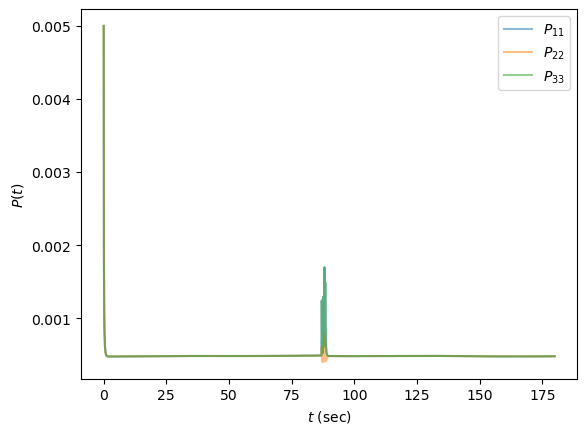

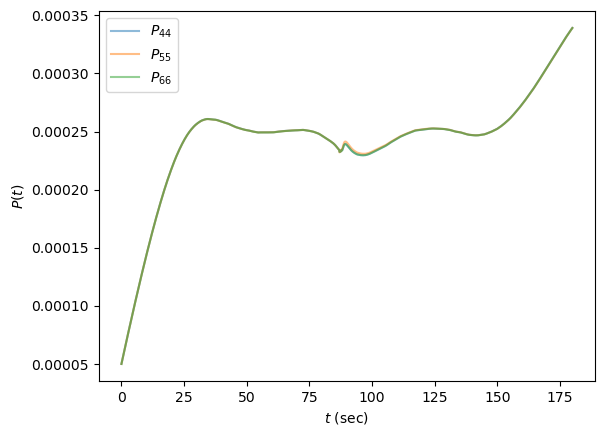

In [195]:
plt.plot(t_data[:], P_arr[:, 0, 0], alpha=0.5, label=r'$P_{11}$')
plt.plot(t_data[:], P_arr[:, 1, 1], alpha=0.5, label=r'$P_{22}$')
plt.plot(t_data[:], P_arr[:, 2, 2], alpha=0.5, label=r'$P_{33}$')
plt.legend()
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$P(t)$')
plt.show()

plt.plot(t_data[:], P_arr[:, 3, 3], alpha=0.5, label=r'$P_{44}$')
plt.plot(t_data[:], P_arr[:, 4, 4], alpha=0.5, label=r'$P_{55}$')
plt.plot(t_data[:], P_arr[:, 5, 5], alpha=0.5, label=r'$P_{66}$')
plt.legend()
plt.xlabel(r'$t$ (sec)')
plt.ylabel(r'$P(t)$')
plt.show()

